<a href="https://colab.research.google.com/github/I-jidd/Data-Analysis/blob/main/Middle_Finger_Realtime_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Setup and Get Data

1.1 Install Dependencies and Setup

In [ ]:
!pip install tensorflow matplotlib opencv-python albumentations labelme

1.2 Collect Images Using OpenCV

In [28]:
#ps. I didn't run this code in colab since colab it won't detect the camera. I execute this locally and collect the data.
import os
import time
import uuid
import cv2

IMAGE_PATH = os.path.join('data','images')
number_images = 40

# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print(f'Collecting image {imgnum}')
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [29]:
#I executed this locally
#!labelme

#2. Review Dataset and Build Image Loading Function

2.1 Import Tf and dependencies

In [30]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

2.2 Load Image into TF Data Pipeline

In [31]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [32]:
images.as_numpy_iterator().next()

b'data/images/447558a6-48cf-11f0-99e9-c0185081cce0.jpg'

In [33]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [34]:
images = images.map(load_image)

array([[[ 88,  91, 124],
        [ 89,  93, 122],
        [ 91,  93, 118],
        ...,
        [162, 153, 154],
        [162, 157, 154],
        [163, 158, 155]],

       [[ 82,  87, 119],
        [ 90,  95, 124],
        [ 87,  92, 114],
        ...,
        [163, 159, 158],
        [161, 157, 156],
        [162, 161, 157]],

       [[ 88,  95, 124],
        [ 94, 101, 127],
        [ 88,  94, 116],
        ...,
        [161, 163, 160],
        [156, 158, 155],
        [157, 162, 158]],

       ...,

       [[119, 160, 178],
        [124, 162, 181],
        [125, 163, 182],
        ...,
        [ 68,  78, 147],
        [ 68,  79, 145],
        [ 62,  73, 139]],

       [[118, 156, 175],
        [122, 160, 179],
        [125, 161, 183],
        ...,
        [ 64,  73, 142],
        [ 67,  76, 143],
        [ 62,  71, 138]],

       [[125, 163, 182],
        [126, 164, 183],
        [126, 161, 183],
        ...,
        [ 57,  66, 135],
        [ 65,  74, 143],
        [ 63,  72, 139]]], dtype=uint8)
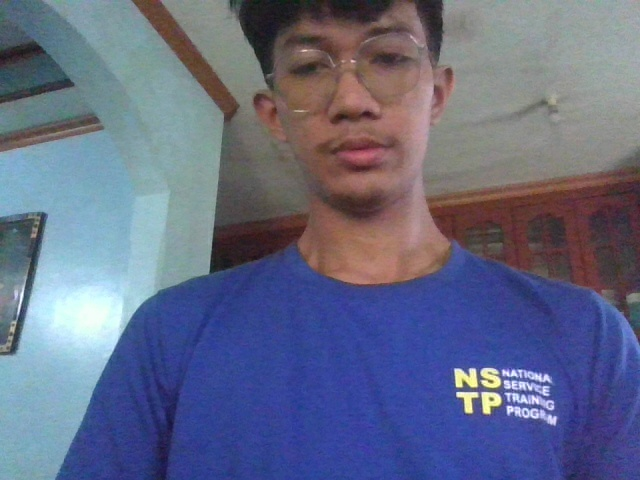

In [35]:
images.as_numpy_iterator().next()

2.3 View Raw Images with Matplotlib

In [38]:
image_generator = images.batch(4).as_numpy_iterator()

In [41]:
plot_images = image_generator.next()

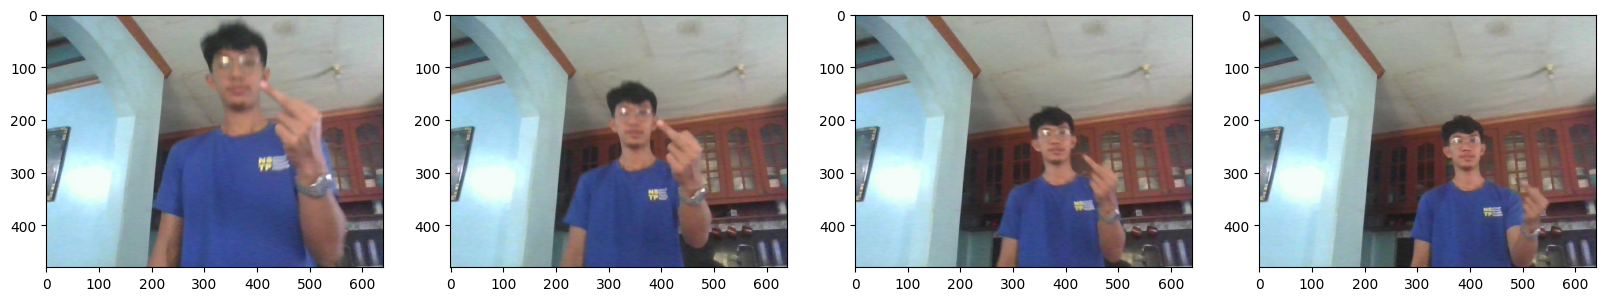

In [42]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

#3. Partition Unaugmented Data

3.1 Split Data

In [48]:
#Manually Split
160 * .7 #train data = 84

112.0

In [49]:
160 * .15 #test data = 18
160 * .15 #val data = 18

24.0

3.2 Move the Matching Labels

In [50]:
for folder in ['train', 'test', 'val']:
  for file in os.listdir(os.path.join('data', folder, 'images')):

    filename = file.split('.')[0]+'.json'
    existing_filepath = os.path.join('data','labels', filename)
    if os.path.exists(existing_filepath):
      new_filepath = os.path.join('data', folder, 'labels', filename)
      os.replace(existing_filepath, new_filepath)

#4. Apply Image Augmentation on Images and Labels using Albumentations

4.1 Setup Albumentations Transform Pipeline

In [51]:
import albumentations as alb

In [52]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.5),
                        alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

4.2 Load a Test Image and Annotation with OpenCV and JSON

In [58]:
img = cv2.imread(os.path.join('data', 'train', 'images','462c19a6-48cf-11f0-96e3-c0185081cce0.jpg'))

In [59]:
with open(os.path.join('data','train', 'labels','462c19a6-48cf-11f0-96e3-c0185081cce0.json'), 'r') as f:
  label = json.load(f)

In [60]:
label

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'middle finger',
   'points': [[387.0731707317073, 193.65853658536588],
    [502.9268292682927, 322.9268292682927]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\462c19a6-48cf-11f0-96e3-c0185081cce0.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNO

4.3 Extract Coordinates and Rescale to Match Image Resolution

In [67]:
label['shapes'][0]['points']

[[387.0731707317073, 193.65853658536588],
 [502.9268292682927, 322.9268292682927]]

In [65]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [66]:
coords

[387.0731707317073, 193.65853658536588, 502.9268292682927, 322.9268292682927]

In [68]:
coords = list(np.divide(coords,[640, 480, 640, 480]))

In [72]:
coords

[np.float64(0.6048018292682926),
 np.float64(0.40345528455284557),
 np.float64(0.7858231707317074),
 np.float64(0.6727642276422764)]

4.4 Apply Augmentations and View Results

In [73]:
augmented = augmentor(image = img, bboxes=[coords], class_labels=['middle finger'])

In [83]:
augmented['bboxes']

[[0.6246070522732204,
  0.33127369774712456,
  0.8820596143934462,
  0.6185365825229221]]

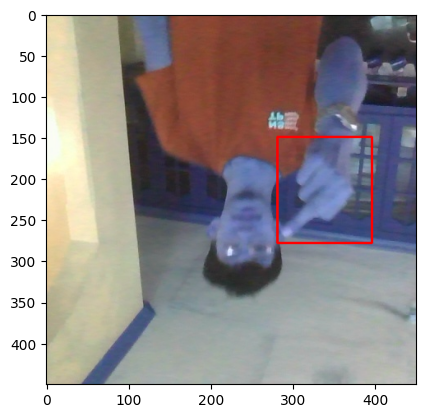

In [84]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented['image'])

#5. Build and Run Augmentation Pipeline

5.1 Run Augmentation Pipeline

In [87]:
for partition in ['train', 'test', 'val']:
  for image in os.listdir(os.path.join('data', partition,'images')):
    img = cv2.imread(os.path.join('data', partition, 'images', image))

    coords = [0,0,0.00001,0.00001]
    label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)

      coords[0] = label['shapes'][0]['points'][0][0]
      coords[1] = label['shapes'][0]['points'][0][1]
      coords[2] = label['shapes'][0]['points'][1][0]
      coords[3] = label['shapes'][0]['points'][1][1]
      coords = list(np.divide(coords,[640, 480, 640, 480]))

    try:
      for x in range(60):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['middle finger'])
        cv2.imwrite(os.path.join('new augmented data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

        annotation = {}
        annotation['image'] = image

        if os.path.exists(label_path):
          if len(augmented['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0
        with open(os.path.join('new augmented data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
          json.dump(annotation, f)

    except Exception as e:
      print(e)

x_max is less than or equal to x_min for bbox [0.61623478 0.27896342 0.32876635 0.         0.        ].
Unsupported image type: <class 'NoneType'>


5.2 Load Augmented Images to Tensorflow Dataset


In [88]:
train_images = tf.data.Dataset.list_files('new augmented data/train/images/*.jpg',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [91]:
test_images = tf.data.Dataset.list_files('new augmented data/test/images/*.jpg',shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [92]:
val_images = tf.data.Dataset.list_files('new augmented data/val/images/*.jpg',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

#6. Prepare Labels

6.1 Build Label Loading Function

In [93]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding='utf-8') as f:
    label = json.load(f)

  return [label['class']], label['bbox']

6.2 Load Labels to Tensorflow Dataset

In [94]:
train_labels = tf.data.Dataset.list_files('new augmented data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [95]:
test_labels = tf.data.Dataset.list_files('new augmented data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [96]:
val_labels = tf.data.Dataset.list_files('new augmented data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [97]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

#7. Combine Label and Image Samples

7.1 Check Partition Lengths

In [98]:
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(6660, 6660, 1440, 1440, 1440, 1440)

7.2 Create Final Datasets (Images/Labels)

In [115]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(16)
train = train.prefetch(8)

In [116]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(7000)
test = test.batch(16)
test = test.prefetch(8)

In [117]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(7000)
val = val.batch(16)
val = val.prefetch(8)

In [202]:
train.as_numpy_iterator().next()[0].shape

(16, 120, 120, 3)

7.3 View Images and Annotations

In [119]:
data_samples = train.as_numpy_iterator()

In [134]:
res = data_samples.next()

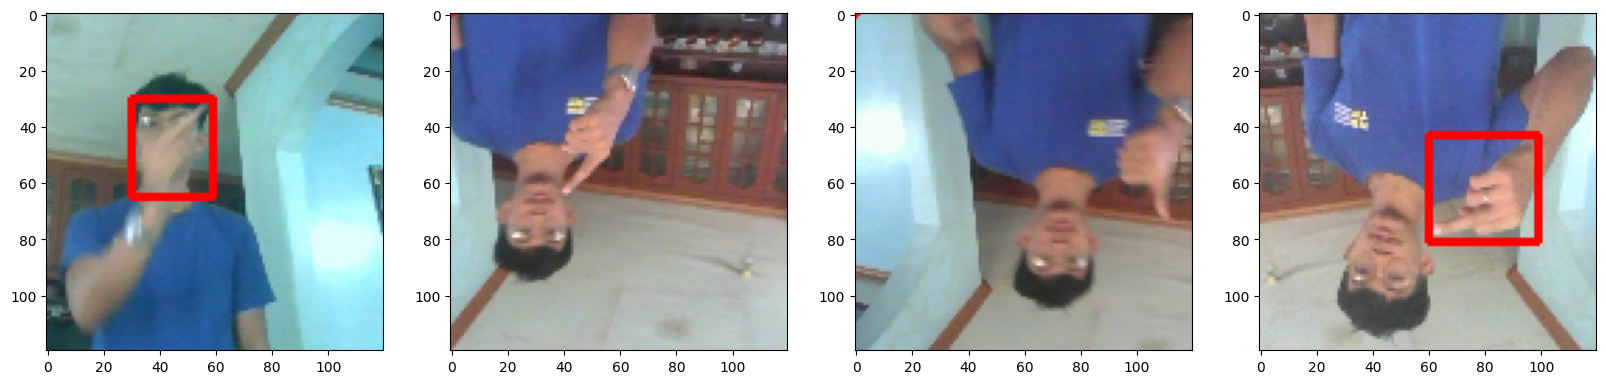

In [135]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx in range(4):
  sample_image = res[0][idx].copy()
  sample_coords = res[1][1][idx]

  cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                (255, 0, 0), 2)

  ax[idx].imshow(sample_image)

#8. Build Deep Learning using the Functional API

8.1 Import Layers and Base Network

In [145]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

8.2 Download VGG16

In [141]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [142]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

8.3 Build instance of Network

In [148]:
def build_model():
  input_layer = Input(shape=(120,120,3))

  vgg = VGG16(include_top=False)(input_layer)

  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1)

  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation ='relu')(f2)
  regress2 = Dense(4, activation='sigmoid')(regress1)

  middle_finger_tracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return middle_finger_tracker

8.4 Test out Neural Network

In [239]:
middle_finger_tracker = build_model()

In [240]:
middle_finger_tracker.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      2,049 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │      8,196 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
X, y = train.as_numpy_iterator().next()

In [241]:
classes, coords = middle_finger_tracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [242]:
classes, coords

(array([[0.6690615 ],
        [0.65750253],
        [0.6555879 ],
        [0.709106  ],
        [0.72635114],
        [0.7013705 ],
        [0.7091633 ],
        [0.7276692 ],
        [0.6840777 ],
        [0.65156704],
        [0.6422584 ],
        [0.71381897],
        [0.6372091 ],
        [0.69877094],
        [0.7011519 ],
        [0.75541466]], dtype=float32),
 array([[0.43529737, 0.46064594, 0.42683738, 0.49581492],
        [0.55563617, 0.48872116, 0.44501492, 0.49305508],
        [0.40846667, 0.40957308, 0.4011489 , 0.47719145],
        [0.410678  , 0.4459464 , 0.38349697, 0.40815753],
        [0.39023343, 0.45788008, 0.44546756, 0.46991488],
        [0.4841519 , 0.47628003, 0.43746024, 0.47925925],
        [0.53203934, 0.42897192, 0.31046316, 0.6257562 ],
        [0.5127377 , 0.5937061 , 0.4151044 , 0.5402818 ],
        [0.54386324, 0.4682989 , 0.36135572, 0.56285405],
        [0.43164906, 0.40673694, 0.42093813, 0.529601  ],
        [0.5232745 , 0.41314328, 0.40916917, 0.5375

#9. Define Losses and Optimizers

9.1 Define Optimizer and LR

In [174]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [175]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


9.2 Create Localization Loss and Classification Loss

In [158]:
def localization_loss(y_true, yhat):
  delta_coord =tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]

  h_pred = yhat[:,3] - yhat[:,1]
  w_pred = yhat[:,2] - yhat[:,0]

  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

  return delta_coord + delta_size

In [177]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

9.3 Test out Loss Metrics

In [162]:
localization_loss(y[1], coords).numpy()

np.float32(7.7960005)

In [164]:
classloss(y[0], classes).numpy()

np.float32(0.64760184)

In [165]:
regressloss(y[1], coords).numpy()

np.float32(7.7960005)

#10. Train Neural Network

10.1 Create custom model class

In [254]:
from threading import local
class Middle_Finger_Tracker(Model):
  def __init__(self, middle_finger_traker, **kwargs):
    super().__init__(**kwargs)
    self.model = middle_finger_traker

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs= classloss
    self.lloss = localization_loss
    self.opt = opt

  def train_step(self, batch, **kwargs):

    X, y= batch

    with tf.GradientTape() as tape:
      classes, coords = self.model(X, training = True)

      batch_classloss = self.closs(y[0], classes)
      batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

      total_loss = batch_localizationloss+ 0.5*batch_classloss
      grad = tape.gradient(total_loss, self.model.trainable_variables)

    opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"total_loss":total_loss, "class_loss": batch_classloss, "regress_loss":batch_localizationloss}

  def test_step(self,batch, **kwargs):
    X, y = batch

    classes,coords = self.model(X, training=False)

    batch_classloss = self.closs(y[0], classes)
    batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
    total_loss = batch_localizationloss+0.5*batch_classloss

    return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

In [244]:
model = Middle_Finger_Tracker(middle_finger_tracker)

In [245]:
model.compile(opt, classloss, regressloss)

10.2 Train

In [183]:
logdir = 'logs'

In [184]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [255]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/40


ValueError: Cannot take the length of shape with unknown rank.